In [2]:
import torch
from matplotlib import pyplot as plt
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

In [5]:
root_path = "/home/yigit/projects/mbcnp/outputs/combined/last/"
run_id, model_folder = '1696363331', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

cnp_model_path, wta_model_path = f'{models_path}cnp_on_synth.pt', f'{models_path}wta_on_synth.pt'

Text(0.5, 1.0, 'Trajectories')

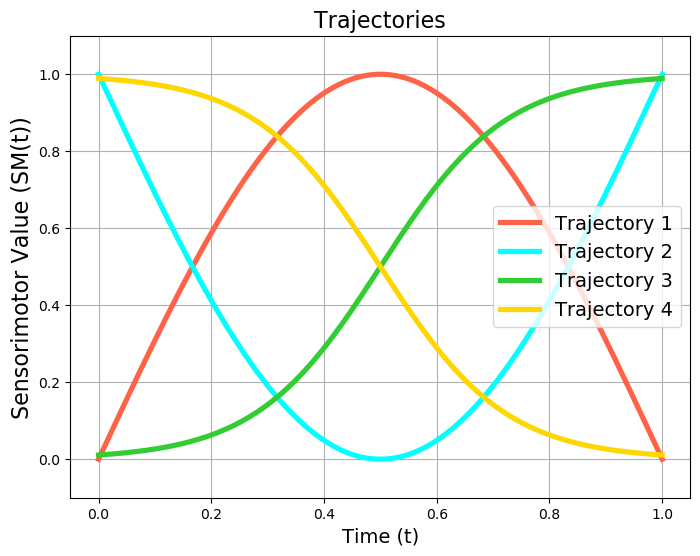

In [11]:
y = torch.load(f'{root_path}{run_id}/y.pt')
num_samples = y.shape[0]
# print(y.shape)

x = torch.linspace(0, 1, 200).repeat(num_samples, 1).view(num_samples, -1, 1)
colors = ['tomato', 'aqua', 'limegreen', 'gold', 'mediumslateblue', 'lightcoral', 'darkorange', 'teal']

test_ind = 99

plt_y_lim_up = torch.max(y) + 0.1
plt_y_lim_low = torch.min(y) - 0.1

plt.figure(figsize=(8, 6))
plt.ylim((plt_y_lim_low, plt_y_lim_up))
for i in range(num_samples):
    plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), colors[i%num_samples], label="Trajectory {}".format(i+1), linewidth=3.75)
    # plt.scatter(x[i, test_ind, 0], y[i, test_ind, 0], c='k')

test_x = x[0, test_ind, 0].item()

# plt.plot([test_x]*200, torch.linspace(-1, 1, 200), 'k--', alpha=0.5)

plt.legend(loc='best', fontsize=14)
plt.grid(True)
plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('Sensorimotor Value (SM(t))', fontsize=16)
plt.title(f'Trajectories', fontsize=16)

In [70]:
batch_size = 4
cnp = CNP(input_dim=1, hidden_dim=406, output_dim=1, n_max_obs=10, n_max_tar=10, num_layers=3, batch_size=batch_size)
wta = WTA_CNP(1, 1, 10, 10, [256, 256, 256], num_decoders=4, decoder_hidden_dims=[256, 256, 256], batch_size=batch_size)

cnp.load_state_dict(torch.load(cnp_model_path))
wta.load_state_dict(torch.load(wta_model_path))

cnp.eval()
wta.eval()

WTA_CNP(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
  (decoders): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=257, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
  )
  (gate): Sequential(
    (0): Linear(in_features=256, out_features=4, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [71]:
# obs = torch.Tensor([1.0, 0.0]).unsqueeze(0).unsqueeze(0)
obs = torch.zeros(num_samples, 1, 2)
for i in range(num_samples):
    obs[i, 0, 0] = x[i, test_ind, 0]
    obs[i, 0, 1] = y[i, test_ind, 0]
tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).repeat(num_samples, 1, 1)

# print(obs.shape, tar.shape)

with torch.no_grad():
    pred_cnp, _ = cnp(obs, tar)
    pred_wta, gate = wta(obs, tar)

print(obs)
print(pred_wta.shape, pred_cnp.shape, gate.shape)
print(gate)

tensor([[[4.9749e-01, 9.9997e-01]],

        [[4.9749e-01, 3.1173e-05]],

        [[4.9749e-01, 4.9435e-01]],

        [[4.9749e-01, 5.0565e-01]]])
torch.Size([4, 4, 200, 2]) torch.Size([4, 200, 2]) torch.Size([4, 1, 4])
tensor([[[1.0000e+00, 1.5262e-06, 2.9241e-08, 9.3615e-09]],

        [[4.0792e-11, 1.2655e-08, 7.0256e-08, 1.0000e+00]],

        [[9.7612e-06, 7.6063e-01, 2.3904e-01, 3.1461e-04]],

        [[1.0027e-05, 6.7679e-01, 3.2290e-01, 2.9341e-04]]])


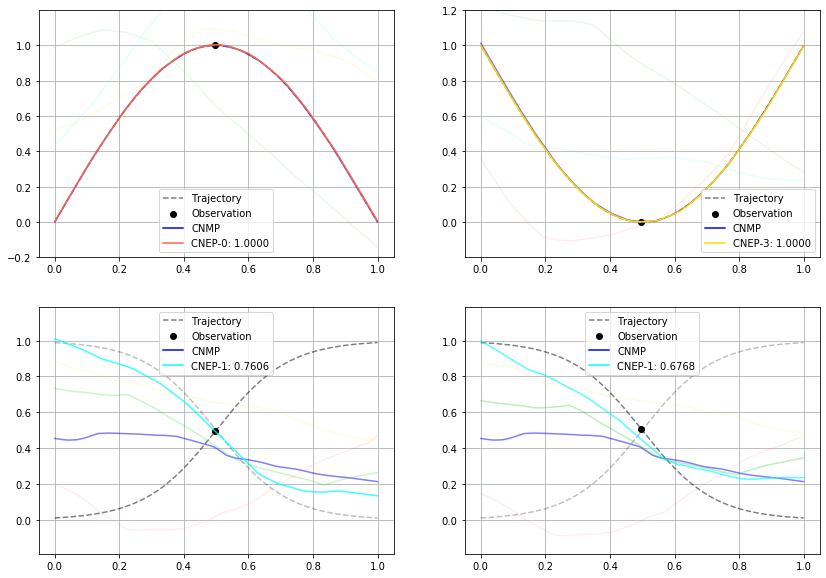

In [72]:
from matplotlib.lines import Line2D

rows, cols = torch.ceil(torch.sqrt(torch.tensor(batch_size))).int(), torch.floor(torch.sqrt(torch.tensor(batch_size))).int()
rows, cols = rows.item(), cols.item()
fig, axs = plt.subplots(rows, cols, figsize=(14, 10))
for i in range(rows):
    for j in range(cols):
        ind = i*cols+j
        plt_y_upper_lim, plt_y_lower_lim = torch.max(y[ind]) + 0.2, torch.min(y[ind]) - 0.2

        axs[i, j].scatter(x[ind, test_ind, 0], y[ind, test_ind, 0], label='Observation', c='k')
        axs[i, j].set_ylim((plt_y_lower_lim, plt_y_upper_lim))
        axs[i, j].plot(torch.linspace(0, 1, 200), y[ind], 'k--', alpha=0.5, label='Trajectory')  # data
        if ind == 2:
            axs[i, j].plot(torch.linspace(0, 1, 200), y[3], 'k--', alpha=0.25)  # data
        if ind == 3:
            axs[i, j].plot(torch.linspace(0, 1, 200), y[2], 'k--', alpha=0.25)  # data
        # axs[i, j].plot(torch.linspace(0, 1, 200), y[3-ind], 'k--', alpha=0.25)  # data
        axs[i, j].plot(torch.linspace(0, 1, 200), pred_cnp[ind,:,0], 'b', alpha=0.5)  # cnp predictions

        handles = axs[i, j].get_legend_handles_labels()[0]
        handles.extend([Line2D([0], [0], label='CNMP', color='b')])

        best = torch.argmax(gate[ind, 0, :]).item()
        for k in range(gate.shape[-1]):
            axs[i, j].plot(torch.linspace(0, 1, 200), pred_wta[k,ind,:,0], colors[k%batch_size], alpha=max(0.1, gate[ind, 0, k].item()))  # wta predictions
            if k==best:
                handles.extend([Line2D([0], [0], label=f'CNEP-{k}: {gate[ind, 0, k].item():.4f}', color=colors[k])])

        axs[i, j].legend(handles=handles, loc='best')
        axs[i, j].grid(True)
        

In [27]:
rr = torch.cat((torch.cat((torch.tensor(y[0, 80, :]), torch.tensor(y[0, 120, :])), dim=0).unsqueeze(0), torch.cat((torch.tensor(y[1, 80, :]), torch.tensor(y[1, 120, :])), dim=0).unsqueeze(0)), dim=0).unsqueeze(-1)
# print(rr.shape)  # 2-2-1
wta.loss(pred_wta, gate.squeeze(1), rr)

/tmp/ipykernel_8279/1920264534.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rr = torch.cat((torch.cat((torch.tensor(y[0, 80, :]), torch.tensor(y[0, 120, :])), dim=0).unsqueeze(0), torch.cat((torch.tensor(y[1, 80, :]), torch.tensor(y[1, 120, :])), dim=0).unsqueeze(0)), dim=0).unsqueeze(-1)


(tensor(-44.9983), tensor(-4.7696))

In [7]:
# plt.ylim((-2.5, 2.5))

# plt.errorbar(torch.linspace(0, 1, 200), pred_cnp[0,:,0], yerr=pred_cnp[0,:,1])
# plt.plot(torch.linspace(0, 1, 200), pred_wta[1,0,:,0], 'k')

In [8]:
# plt.ylim((-2.5, 2.5))
# ind = 0
# plt.errorbar(torch.linspace(0, 1, 200), pred_wta[ind,0,:,0], yerr=pred_wta[ind,0,:,1])